## Import libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [76]:
from srs.weather import read_all_raw_weather_data, save_curated_weather_data
from srs.analysis import plot_missing_values, plot_max_median, interpolate_missing_values

## Read data

In [82]:
data = read_all_raw_weather_data()

In [83]:
data

,Time,Condition,Temperature C,Wind Speed kph
0,2020-01-01 01:00:00,Mostly Cloudy,2.0,19.0
1,2020-01-01 02:00:00,Mostly Cloudy,2.0,19.0
2,2020-01-01 03:00:00,Mostly Cloudy,2.0,22.0
3,2020-01-01 04:00:00,Cloudy,2.0,16.0
4,2020-01-01 05:00:00,Cloudy,2.0,16.0
...,...,...,...,...
8778,2020-12-31 19:00:00,Mist,-2.0,8.0
8779,2020-12-31 20:00:00,Mist,-3.0,9.0
8780,2020-12-31 21:00:00,Mist,-2.0,4.0
8781,2020-12-31 22:00:00,Mist,-2.0,8.0


### Check missing values

In [27]:
data.isnull().sum()

Time               0
Condition         62
Temperature C     62
Wind Speed kph    62
dtype: int64

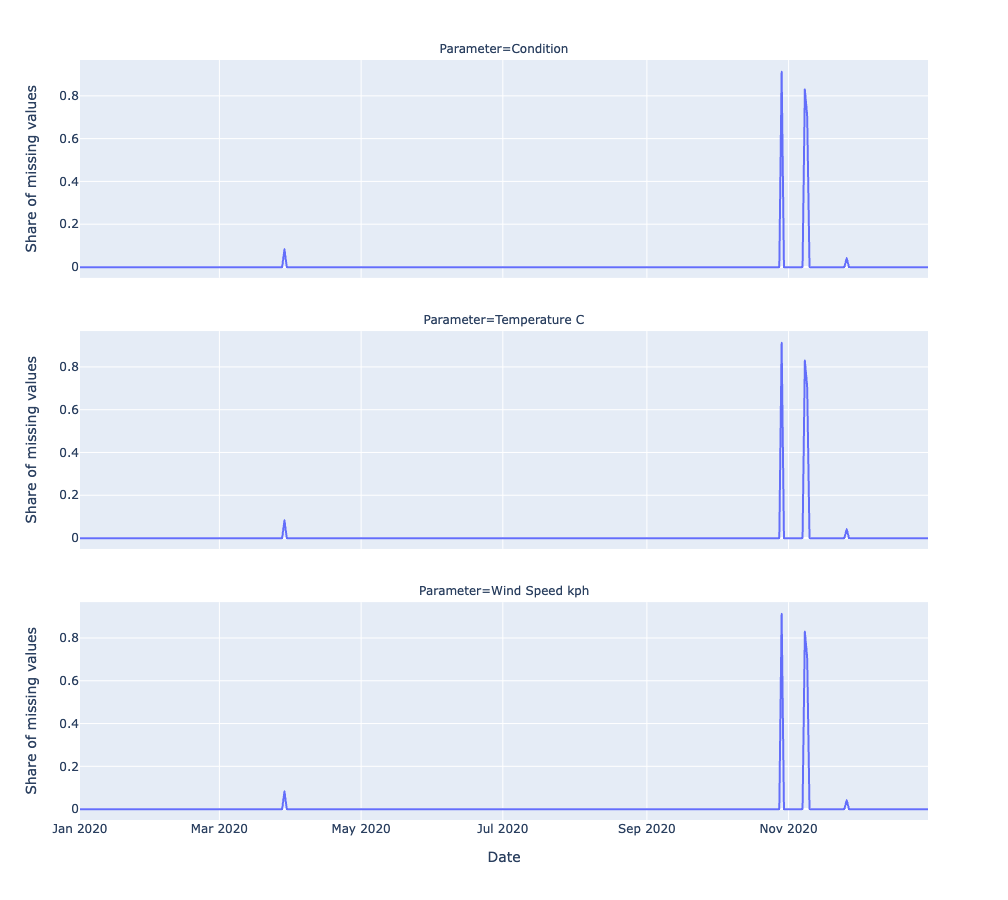

In [32]:
plot_missing_values(data, ['Condition', 'Temperature C', 'Wind Speed kph'])

In [84]:
data['Condition'] = data['Condition'].ffill(limit=3)

data = interpolate_missing_values(data, data.columns.tolist()[2:])

9 values interpolated for Temperature C
9 values interpolated for Wind Speed kph


In [85]:
data.isnull().sum()

Time               0
Condition         53
Temperature C     53
Wind Speed kph    53
dtype: int64

### Explore the data

In [88]:
data.sample(10)

,Time,Condition,Temperature C,Wind Speed kph
1705,2020-03-12 02:00:00,Fair,6.0,12.0
2835,2020-04-28 04:00:00,Fair,7.0,8.0
7026,2020-10-19 19:00:00,Fair,7.0,9.0
8645,2020-12-26 06:00:00,Cloudy,1.0,19.0
1336,2020-02-25 17:00:00,Light Rain Shower / Windy,6.0,37.0
2379,2020-04-09 04:00:00,Fair,5.0,1.0
4833,2020-07-20 10:00:00,Fair,25.0,11.0
523,2020-01-22 20:00:00,Fair,0.0,11.0
6423,2020-09-24 16:00:00,Fair,23.0,11.0
4671,2020-07-13 16:00:00,Fair,22.0,9.0


What does the `windy` label in `Condition` mean?

In [90]:
def check_windy_label(data):
    df = data.copy()
    df['Is Windy'] = df['Condition'].str.contains('Windy')
    return df[['Is Windy', 'Wind Speed kph']].groupby('Is Windy').agg(['min', 'mean', 'max'])

In [92]:
check_windy_label(data)

Wind Speed kph                 
                    min       mean   max
Is Windy                                
False               0.0  12.596793  32.0
True               33.0  35.596154  49.0

Data has a `Windy` label when the wind speed is over 32kph.

What are the conditions?

In [93]:
conditions = data['Condition'].str.replace(' / Windy', '').value_counts()
conditions

Fair                       5088
Mostly Cloudy              1042
Cloudy                      672
Mist                        516
Partly Cloudy               447
Light Rain                  444
Light Rain Shower           196
Fog                         118
Light Drizzle                89
Shallow Fog                  32
Light Snow Shower            13
Rain                         11
Rain Shower                  11
Wintry Mix                   10
Light Rain with Thunder      10
Light Snow                    9
Thunder                       6
T-Storm                       4
Drizzle                       3
Patches of Fog                3
Snow                          3
Haze                          1
Thunder in the Vicinity       1
Heavy T-Storm                 1
Name: Condition, dtype: int64

/Users/monikakubek/Repositories/air-quality-analysis/analyses/srs/analysis.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



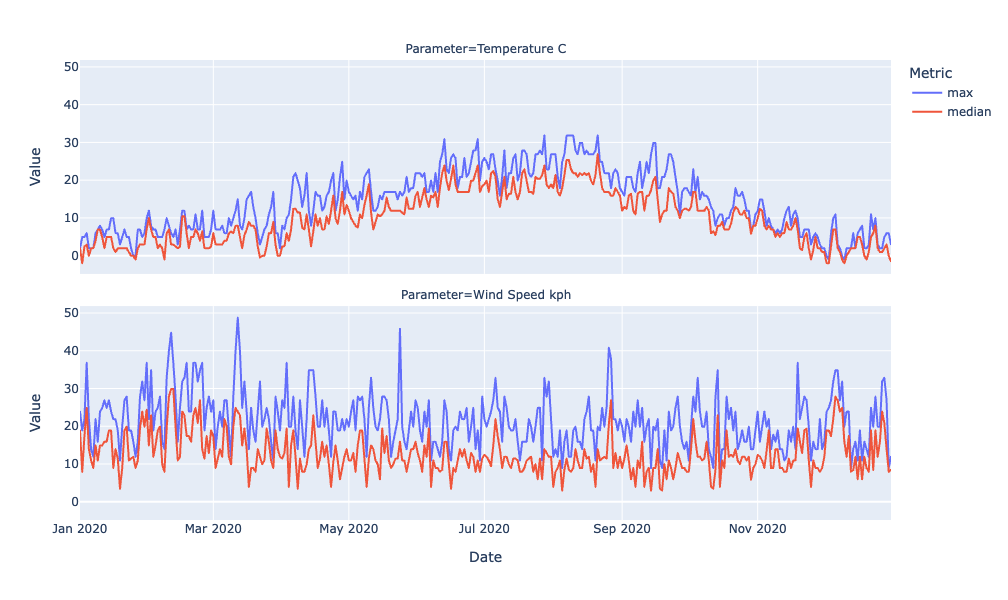

In [94]:
plot_max_median(data, ['Temperature C', 'Wind Speed kph'])

### Extract features

In [95]:
def cloudiness_level(condition):
    """Map condition to the cloudiness level"""
    if condition == 'Fair':
        return 'Fair'
    if condition in ('Partly Cloudy', 'Thunder in the Vicinity'):
        return 'Partly Cloudy'
    if condition in ('Cloudy', 'Light Rain', 'Light Rain Shower', 'Light Drizzle', 'Light Snow Shower',
                    'Rain', 'Rain Shower', 'Wintry Mix', 'Light Rain with Thunder', 'Light Snow'
                    'Thunder', 'T-Storm', 'Drizzle', 'Snow', 'Heavy T-Storm', 'Mostly Cloudy'):
        return 'Cloudy'
    if condition in ('Mist', 'Fog', 'Shallow Fog', 'Patches of Fog', 'Haze'):
        return 'Fog'


def precipitation_level(condition):
    """Map condition to the precipitation level"""
    if condition in ('Rain', 'Rain Shower', 'Wintry Mix', 'T-Storm', 'Snow', 'Heavy T-Storm'):
        return 'Heavy'
    if condition in ('Light Rain', 'Light Rain Shower', 'Light Drizzle', 'Light Snow Shower', 
                     'Light Rain with Thunder', 'Light Snow', 'Drizzle'):
        return 'Light'
    else:
        return 'None'

In [96]:
def create_weather_features(data):
    """Create new features"""
    df = data.copy()
    condition = df.pop('Condition').str.replace(' / Windy', '')
    
    df['Cloudiness Level'] = condition.apply(cloudiness_level)
    df['Precipitation Level'] = condition.apply(precipitation_level)
    
    return df

In [97]:
create_weather_features(data)

,Time,Temperature C,Wind Speed kph,Cloudiness Level,Precipitation Level
0,2020-01-01 01:00:00,2.0,19.0,Cloudy,None
1,2020-01-01 02:00:00,2.0,19.0,Cloudy,None
2,2020-01-01 03:00:00,2.0,22.0,Cloudy,None
3,2020-01-01 04:00:00,2.0,16.0,Cloudy,None
4,2020-01-01 05:00:00,2.0,16.0,Cloudy,None
...,...,...,...,...,...
8778,2020-12-31 19:00:00,-2.0,8.0,Fog,None
8779,2020-12-31 20:00:00,-3.0,9.0,Fog,None
8780,2020-12-31 21:00:00,-2.0,4.0,Fog,None
8781,2020-12-31 22:00:00,-2.0,8.0,Fog,None


In [ ]:
save_curated_weather_data(data)